# LSI convergence for log-concave marginals

In [36]:
%pip install emcee
%pip install scikit-learn
%pip install pot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 KB 7.6 MB/s eta 0:00:007.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np

In [16]:
from LSI_helpers import epsilon_c, kappa_X_given_Y, kappa_Y_given_X, rate_r
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

In [17]:
delta = 0.1

def U(x):
    return 0.5 * x**2 + delta * np.sin(x)**2

def grad_U(x):
    return x + delta * np.sin(2*x)

def V(y):
    return 1.5 * y**2 + delta * np.sin(y)**2

def grad_V(y):
    return 3.0 * y + delta * np.sin(2*y)

In [18]:
alpha_u, beta_u = 0.8, 1.2
alpha_v, beta_v = 2.8, 3.2

eps = 0.2       # must exceed ε_c for these U, V
N = 1000        # number of particles
dt = 1e-3       # time-step
T = 5.0         # final time

eps_c_val = epsilon_c(alpha_u, alpha_v, beta_u, beta_v)
kX = kappa_X_given_Y(alpha_u, beta_v, eps)
kY = kappa_Y_given_X(alpha_v, beta_u, eps)
r_val = rate_r(kX, kY, eps)

steps = int(T / dt)
times = np.linspace(0.0, T, steps + 1)

## MCMC sampling from $\exp{-U(x)}$ and $\exp{-V(y)}$ 

In [31]:
import emcee

# (Assume U(x), V(y), and rng are already defined above.)

# 1) Define log‐probability for U
def log_prob_U(theta):
    x = theta[0]          # theta is a length-1 array [x]
    return -U(x)          # log π₁(x) = −U(x)

# 2) Sampler parameters
ndim     = 1
nwalkers = 40
nburn    = 1000
nsteps   = 125

# 3) Initialize walkers for U
rng = np.random.default_rng(0)
p0 = rng.normal(loc=0.0, scale=0.1, size=(nwalkers, ndim))

# 4) Burn-in for U
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_U)
pos, _, _ = sampler.run_mcmc(p0, nburn, progress=False)

# 5) Production for U
sampler.reset()
sampler.run_mcmc(pos, nsteps, progress=False)

# 6) Extract U-samples
chain = sampler.get_chain(flat=True)   # shape = (nwalkers * nsteps, ndim)
X0 = chain[:, 0]
print("Collected", X0.shape[0], "samples from π(x) ∝ exp(-U(x)).")

# —————————————————————————————————————————————

# 7) Define log‐probability for V
def log_prob_V(theta):
    y = theta[0]
    return -V(y)          # log π₂(y) = −V(y)

# 8) Initialize walkers for V (this was missing)
p0_V = rng.normal(loc=0.0, scale=0.1, size=(nwalkers, ndim))

# 9) Burn-in for V
sampler_V = emcee.EnsembleSampler(nwalkers, ndim, log_prob_V)
pos_V, _, _ = sampler_V.run_mcmc(p0_V, nburn, progress=False)

# 10) Production for V
sampler_V.reset()
sampler_V.run_mcmc(pos_V, nsteps, progress=False)

# 11) Extract V-samples
chain_V = sampler_V.get_chain(flat=True)
Y0 = chain_V[:, 0]
print("Collected", Y0.shape[0], "samples from π(y) ∝ exp(-V(y)).")


Collected 5000 samples from π(x) ∝ exp(-U(x)).
Collected 5000 samples from π(y) ∝ exp(-V(y)).


## EM scheme

In [ ]:
dt = 0.01
eps = 0.5
num_steps = 500
T = num_steps*dt
errors, X_traj, Y_traj, _, mY_hist, mX_hist = euler_maruyama_coupling(
    X0,
    Y0,
    epsilon=eps,
    T=T,
    N=num_steps,
    cond_method='isotonic',
    h=None,
    k=None,
    grad_U=grad_U,
    grad_V=grad_V,
    compute_W2_sq=None,
    seed=42
)
emp_wasserstein = W2_empirical(X0, Y0)
print(emp_wasserstein)

0.1885664017641671


In [33]:
alpha_u = 0.8
beta_u  = 1.2
alpha_v = 2.8
beta_v  = 3.2

eps_c_val = epsilon_c(alpha_u, alpha_v, beta_u, beta_v)
print(eps_c_val)

0.15748519708717798


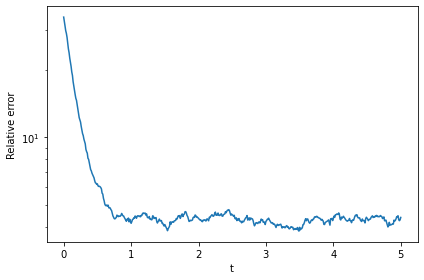

In [42]:
import matplotlib.pyplot as plt

times = np.arange(num_steps + 1) * dt
rel_error = (errors - emp_wasserstein)**2 / emp_wasserstein**2

plt.figure()
plt.plot(times, rel_error)
plt.xlabel('t')
plt.ylabel('Relative error')
plt.yscale('log')
plt.tight_layout()
plt.show()

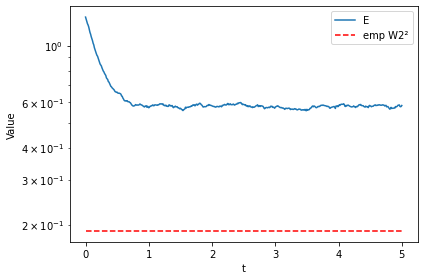

In [43]:
times = np.arange(num_steps + 1) * dt

plt.figure()
plt.plot(times, errors, label='E')
plt.hlines(emp_wasserstein, times[0], times[-1],
           colors='r', linestyles='--', label='emp W2²')
plt.xlabel('t')
plt.ylabel('Value')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
import ot

In [ ]:
# 1. Evaluate the unnormalized “pdf” of μ at each X0[i]:  wX_raw[i] = e^{-U(X0[i])}
wX_raw = np.exp(-U(X0))        # shape: (N,)

# 2. Normalize so that sum_i a[i] = 1
a = wX_raw / np.sum(wX_raw)    # shape: (N,)

# 3. Do the same for ν:  wY_raw[j] = e^{-V(Y0[j])}
wY_raw = np.exp(-V(Y0))        # shape: (N,)
b = wY_raw / np.sum(wY_raw)    # shape: (N,)

# -------------------------------------------------------------------------
# B) Build the cost matrix M_{ij} = (X0[i] - Y0[j])^2   (or 0.5*(x-y)^2 if you prefer)
# -------------------------------------------------------------------------
# If you want c(x,y)=|x-y|^2, then:
M = (X0.reshape(-1, 1) - Y0.reshape(1, -1))**2   # shape: (N, N)

In [40]:
P_es = ot.bregman.sinkhorn_epsilon_scaling(
            a,
            b,
            M,
            eps,
            stopThr=1e-9,
            numItermax=1000,
            tau=1e6,
        )

W_es = np.sum(P_es*M)
print(W_es)

0.28433779395302416
